## JIRA Bug report

In [1]:
import requests
import json
import os
from dotenv import load_dotenv

## Fetch DATA

In [2]:
#### Global variables

filterSKR01 = {"jql" : "filter = 10250"}
filterSKR10 = {"jql" : "filter = 10251"}

load_dotenv()

jira_token_path = os.environ.get('jr_token')
print(f"Getting token successful: {jira_token_path[:3]}...{jira_token_path[-3:]}")

Getting token successful: ATA...48F


In [3]:
# rsrc = "search"

# endpoint = "https://skrmobileapp.atlassian.net/rest/api/3/{resrc}".format( 
#     resrc = rsrc,
#     )

# jira_user = 'punnathorn.mingkwan@sikarin.com'
# auth = requests.auth.HTTPBasicAuth(jira_user, jira_token_path)
# head = {
#     "Accept": "application/json",
#     }

# response = requests.get(url = endpoint, headers = head, auth = auth, params = filterSKR01)
# # print("STATUS : {response.status_code}")

# allDefectSKR01 = json.loads(response.text)

# allDefectSKR01.keys()

In [4]:
def get_bug_skr(versions = filterSKR01) -> dict:
    rsrc = "search"

    endpoint = "https://skrmobileapp.atlassian.net/rest/api/3/{resrc}".format( 
        resrc = rsrc,
        )

    jira_user = 'punnathorn.mingkwan@sikarin.com'
    auth = requests.auth.HTTPBasicAuth(jira_user, jira_token_path)
    head = {
        "Accept": "application/json",
        }

    response = requests.get(url = endpoint, headers = head, auth = auth, params = versions)
    # print("STATUS : {response.status_code}")

    allDefectSKR01 = json.loads(response.text)

    ############################################
    ############################################
    ###### filter all bugs into a list
    ############################################
    ############################################

    bug_lists = {}
    for i in range(len(allDefectSKR01['issues'])):

        lin = allDefectSKR01['issues'][i]['fields']['votes']['self'].split("rest/api/3/issue/")
        linn = lin[0] + 'browse/' + lin[1]

        linn = linn.removesuffix('/votes')

        assign = None
        if allDefectSKR01['issues'][i]['fields']['assignee'] is not None:
            assign = allDefectSKR01['issues'][i]['fields']['assignee']['displayName']
        
        myBugFormat = {
            'bug_id' : allDefectSKR01['issues'][i]['key'],
            'status' : allDefectSKR01['issues'][i]['fields']['status']['name'],
            'priority' : allDefectSKR01['issues'][i]['fields']['priority']['name'],
            'bug_name' : allDefectSKR01['issues'][i]['fields']['summary'],
            'created' : allDefectSKR01['issues'][i]['fields']['created'],
            'duedate' : allDefectSKR01['issues'][i]['fields']['duedate'],
            'Assignee' : assign,
            'labels' : allDefectSKR01['issues'][i]['fields']['labels'],
            'link' : linn,
        }
        bug_lists[i] = myBugFormat
    return bug_lists

def business_status(strr):
    if strr in ['Drafting', 'Draft ready',] :
        return '00: draft'
    elif strr == 'To Do':
        return '01: to assign'
    elif strr in ['ready-to-fix (assigned)', 'fixing', 'fixed-not-deploy',] :
        return '02: in process'
    elif strr in ['fixed-deployed', 'Rechecking']:
        return '03: to recheck'
    elif strr == 'Draft (need-to-recheck)':
        return '04: to recheck (negative)'
    elif strr == 'Done':
        return '05: done'
    else:
        return '06: cancelled'

In [5]:
drst = get_bug_skr(versions = filterSKR01)
drst2 = get_bug_skr(versions = filterSKR10)

## Create dataframe

In [6]:
from datetime import datetime

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [7]:
current_datetime = datetime.now()
current_date = current_datetime.date()

df = pd.DataFrame.from_dict(drst, orient='index')
df['busn_status'] = df['status'].apply(lambda x: business_status(x))

df2 = pd.DataFrame.from_dict(drst2, orient='index')
df2['busn_status'] = df2['status'].apply(lambda x: business_status(x))

## Report SKR 0.1

In [8]:
print(f"All Bugs : {len(df)}")

All Bugs : 15


In [9]:
status = pd.DataFrame(df.groupby(by=['busn_status'])['bug_id'].agg('count'))\
    .reset_index(drop=False)\
    .rename(columns={'bug_id':'id_counts'})

display(status)

busn_status  id_counts
0                  00: draft          4
1              01: to assign          2
2             02: in process          6
3  04: to recheck (negative)          3

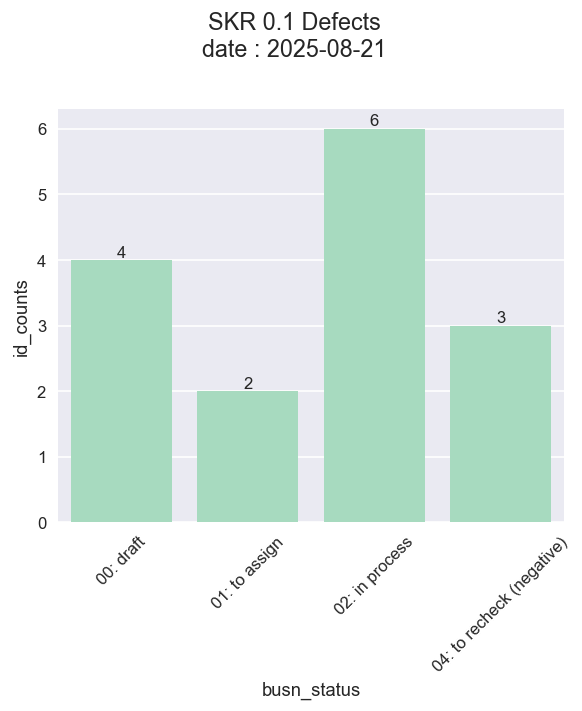

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,6), dpi=120 )

g = sns.barplot(
    data=status,
    x='busn_status',
    order = status['busn_status'].value_counts().index,
    y='id_counts',
    color='#9FE2BF',
    ax=axes
)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)

### Show values in case multi-category
# for i in ax.containers:
#     ax.bar_label(i,)

### Show values in case single-category
axes.bar_label(axes.containers[0])

# g.set_title('flow_type')

fig.suptitle(f"SKR 0.1 Defects\ndate : {current_date}\n", fontsize=14)
fig.tight_layout()
plt.show()

In [11]:
status_priority = pd.DataFrame(df.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    # .reset_index(drop=False)

display(status_priority)

pr_counts
busn_status               priority           
00: draft                 High              2
                          Highest           2
01: to assign             High              2
02: in process            High              2
                          Highest           2
                          Medium            2
04: to recheck (negative) High              1
                          Highest           2

priority                   Highest  High  Medium  Low
busn_status                                          
00: draft                      2.0   2.0     0.0  0.0
01: to assign                  0.0   2.0     0.0  0.0
02: in process                 2.0   2.0     2.0  0.0
04: to recheck (negative)      2.0   1.0     0.0  0.0

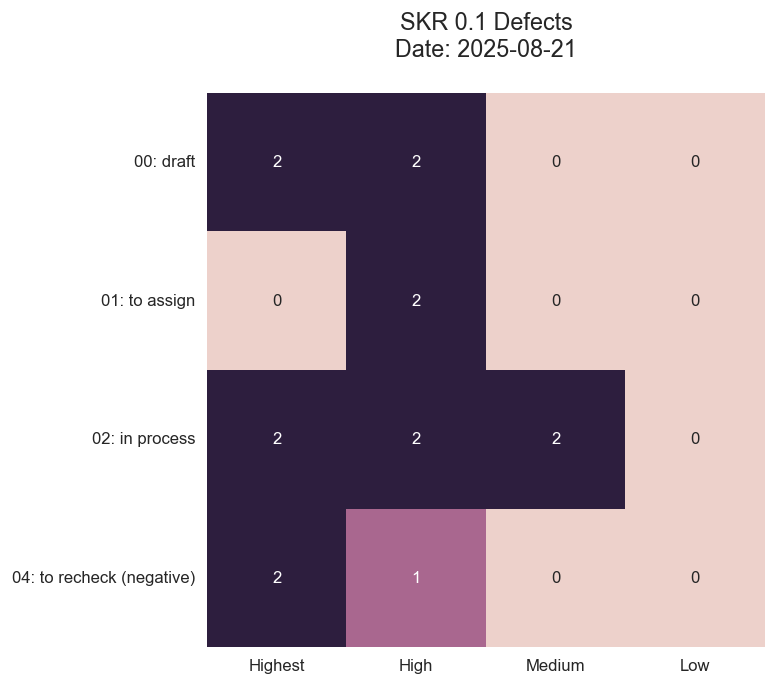

In [12]:
tmp = pd.DataFrame(df.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    .reset_index(drop=False)

tmp = tmp.pivot_table(index='busn_status', columns='priority', values='pr_counts')\
    # .reset_index(drop=False)
tmp = tmp.reindex(columns=['Highest', 'High', 'Medium', 'Low'])
tmp = tmp.fillna(0)
display(tmp)

### PLOT 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120 )

ax = sns.heatmap(tmp, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
plt.title('SKR 0.1 Defects\nDate: {a}\n'.format(a=current_date), fontsize=14)
ax.set(xlabel="", ylabel="")
ax.tick_params(axis='y', labelrotation=0)

In [13]:
for i in df['busn_status'].unique():
    print(f"STATUS: {i}")
    display(df[df['busn_status'] == i].sort_values(by=['priority'], ascending=False))

STATUS: 04: to recheck (negative)


bug_id                   status priority  \
0  SKR-2343  Draft (need-to-recheck)  Highest   
1  SKR-2234  Draft (need-to-recheck)  Highest   
2  SKR-2307  Draft (need-to-recheck)     High   

                                            bug_name  \
0  [MO,BO] อัพโหลดข้อมูล SKC ไปแล้วไม่สามารถเชื่อ...   
1  [BO,Mobile] การแสดง "ผลแล็บ" ในเมนู "ผลตรวจสุข...   
2     [MO] เปลี่ยนภาษาเป็น Eng แต่เมนูยังเป็นภาษาไทย   

                        created duedate           Assignee  \
0  2025-08-06T14:15:14.549+0700    None               None   
1  2025-06-27T17:53:43.135+0700    None    manisara piboon   
2  2025-07-16T13:52:40.108+0700    None  Pongpanot Na ubon   

                            labels  \
0  [SKR0.1, SKR0.1+, form, form-1]   
1           [SKR0.1, form, form-1]   
2           [SKR0.1, form, form-1]   

                                                link  \
0  https://skrmobileapp.atlassian.net/browse/SKR-...   
1  https://skrmobileapp.atlassian.net/browse/SKR-...   
2  https://skrmobileapp.atlassian.net/browse/SKR-...   

                 busn_status  
0  04: to recheck (negative)  
1  04: to recheck (negative)  
2  04: to recheck (negative)

STATUS: 02: in process


bug_id                   status priority  \
7  SKR-2357  ready-to-fix (assigned)   Medium   
8  SKR-2348  ready-to-fix (assigned)   Medium   
3  SKR-2349  ready-to-fix (assigned)  Highest   
4  SKR-2344  ready-to-fix (assigned)  Highest   
5  SKR-2353  ready-to-fix (assigned)     High   
6  SKR-2351  ready-to-fix (assigned)     High   

                                            bug_name  \
7  [ Appointment ][ Sandbox ] slot เวลาที่เต็มแล้...   
8               [MO][Sandbox] Media video ไม่มีเสียง   
3                    [MO] ผลตรวจสุขภาพมีรายการซ้ำกัน   
4                 [ MO ] ผลตรวจสุขภาพโดยรวมมีปี 0001   
5  [ Appointment ] Button สาขา กับ Button บริการ ...   
6  [ MO ][ Sandbox ] กดดู media ประเภท Video, เปิ...   

                        created duedate            Assignee  \
7  2025-08-14T11:19:42.922+0700    None  Nutsongwat Cheawka   
8  2025-08-07T12:35:29.745+0700    None  Nutsongwat Cheawka   
3  2025-08-08T13:59:51.320+0700    None      Purinut Uomrod   
4  2025-08-06T16:54:11.660+0700    None      Purinut Uomrod   
5  2025-08-14T10:40:10.886+0700    None  Nutsongwat Cheawka   
6  2025-08-11T14:47:55.590+0700    None     Tanawat Chanhom   

                            labels  \
7  [SKR0.1, SKR0.1+, form, form-1]   
8  [SKR0.1, SKR0.1+, form, form-1]   
3  [SKR0.1, SKR0.1+, form, form-1]   
4  [SKR0.1, SKR0.1+, form, form-1]   
5  [SKR0.1, SKR0.1+, form, form-1]   
6  [SKR0.1, SKR0.1+, form, form-1]   

                                                link     busn_status  
7  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
8  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
3  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
4  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
5  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
6  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process

STATUS: 00: draft


bug_id       status priority  \
9   SKR-2356  Draft ready  Highest   
10  SKR-2354  Draft ready  Highest   
11  SKR-2350  Draft ready     High   
12  SKR-2345  Draft ready     High   

                                             bug_name  \
9           [ MO ] ผล Lab SKC บางส่วนไม่ได้มาจาก GEMS   
10            [MO] กด refresh ข้อมูลแล้วหาย (Sandbox)   
11  [ MO ] ผล Lab ที่ Upload มีค่า 0 มาด้วย แต่ใน ...   
12         [MO, Lab][Sandbox] ผล Lab SKC โหลดช้าเกิน    

                         created duedate Assignee  \
9   2025-08-14T11:12:20.435+0700    None     None   
10  2025-08-14T10:48:47.902+0700    None     None   
11  2025-08-11T14:13:31.287+0700    None     None   
12  2025-08-07T11:48:00.464+0700    None     None   

                             labels  \
9   [SKR0.1, SKR0.1+, form, form-1]   
10  [SKR0.1, SKR0.1+, form, form-1]   
11  [SKR0.1, SKR0.1+, form, form-1]   
12  [SKR0.1, SKR0.1+, form, form-1]   

                                                 link busn_status  
9   https://skrmobileapp.atlassian.net/browse/SKR-...   00: draft  
10  https://skrmobileapp.atlassian.net/browse/SKR-...   00: draft  
11  https://skrmobileapp.atlassian.net/browse/SKR-...   00: draft  
12  https://skrmobileapp.atlassian.net/browse/SKR-...   00: draft

STATUS: 01: to assign


bug_id status priority  \
13  SKR-2342  To Do     High   
14  SKR-2327  To Do     High   

                                             bug_name  \
13                    [ BO ] ลบ Special clinic ไม่ได้   
14  [ MO, BO ] เปลี่ยนผล Lab SKC ที่เผยแพร่ไปแล้ว ...   

                         created duedate           Assignee  \
13  2025-08-06T08:54:44.027+0700    None  Pongpanot Na ubon   
14  2025-07-31T09:28:05.590+0700    None     Purinut Uomrod   

                             labels  \
13  [SKR0.1, SKR0.1+, form, form-1]   
14           [SKR0.1, form, form-1]   

                                                 link    busn_status  
13  https://skrmobileapp.atlassian.net/browse/SKR-...  01: to assign  
14  https://skrmobileapp.atlassian.net/browse/SKR-...  01: to assign

## Report SKR 1.0

In [14]:
print(f"All Bugs : {len(df2)}")

All Bugs : 6


In [15]:
status2 = pd.DataFrame(df2.groupby(by=['busn_status'])['bug_id'].agg('count'))\
    .reset_index(drop=False)\
    .rename(columns={'bug_id':'id_counts'})

display(status2)

busn_status  id_counts
0              01: to assign          1
1             02: in process          3
2  04: to recheck (negative)          2

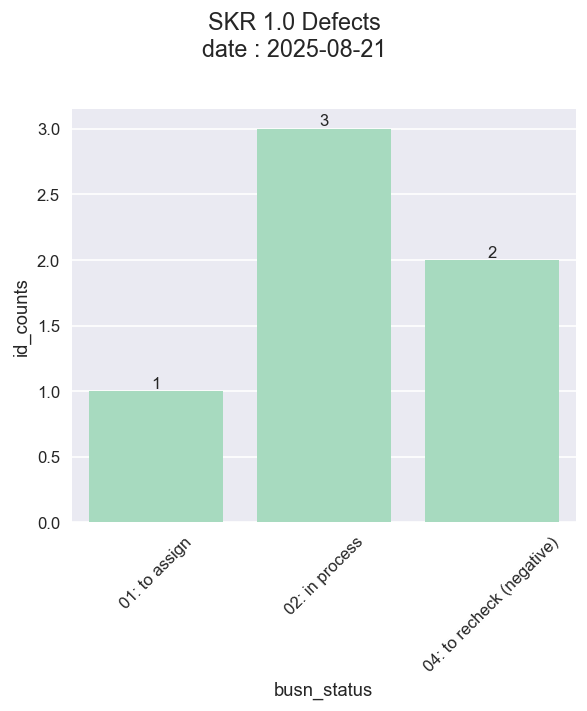

In [16]:
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(5,6), dpi=120 )

g2 = sns.barplot(
    data=status2,
    x='busn_status',
    order = status2['busn_status'].value_counts().index,
    y='id_counts',
    color='#9FE2BF',
    ax=axes2
)

for tickk in axes2.get_xticklabels():
    tickk.set_rotation(45)

### Show values in case multi-category
# for i in ax.containers:
#     axes2.bar_label(i,)

### Show values in case single-category
axes2.bar_label(axes2.containers[0])

# g2.set_title('flow_type')

fig2.suptitle(f"SKR 1.0 Defects\ndate : {current_date}\n", fontsize=14)
fig2.tight_layout()
plt.show()

In [17]:
status_priority2 = pd.DataFrame(df2.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    # .reset_index(drop=False)

display(status_priority2)

pr_counts
busn_status               priority           
01: to assign             Medium            1
02: in process            Medium            3
04: to recheck (negative) High              2

priority                   Highest  High  Medium  Low
busn_status                                          
01: to assign                  0.0   0.0     1.0  0.0
02: in process                 0.0   0.0     3.0  0.0
04: to recheck (negative)      0.0   2.0     0.0  0.0

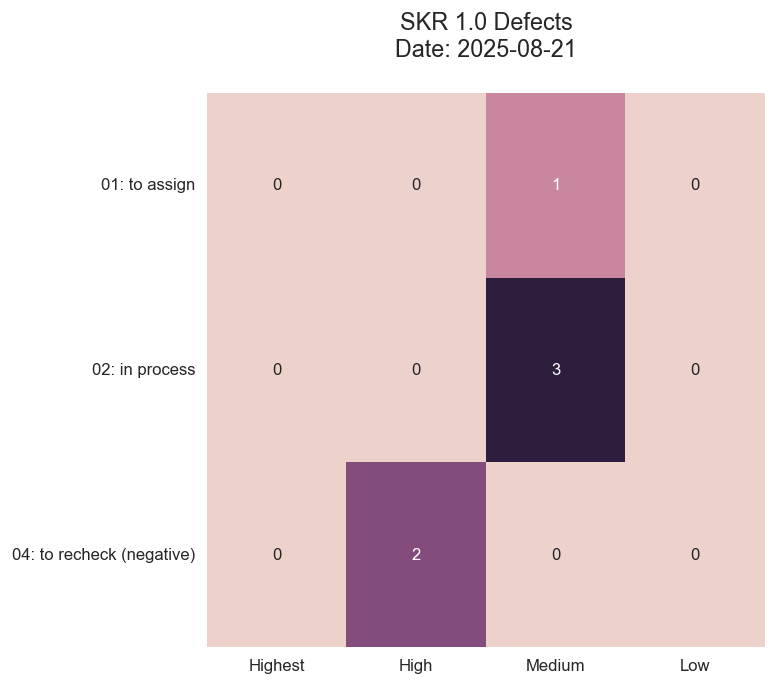

In [18]:
tmp2 = pd.DataFrame(df2.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    .reset_index(drop=False)

tmp2 = tmp2.pivot_table(index='busn_status', columns='priority', values='pr_counts')\
    # .reset_index(drop=False)

tmp2 = tmp2.reindex(columns=['Highest', 'High', 'Medium', 'Low'])
tmp2 = tmp2.fillna(0)
display(tmp2)

### PLOT 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120 )

ax = sns.heatmap(tmp2, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
plt.title('SKR 1.0 Defects\nDate: {a}\n'.format(a=current_date), fontsize=14)
ax.set(xlabel="", ylabel="")
ax.tick_params(axis='y', labelrotation=0)

In [19]:
for i2 in df2['busn_status'].unique():
    print(f"STATUS: {i2}")
    display(df2[df2['busn_status'] == i2].sort_values(by=['priority'], ascending=False))

STATUS: 04: to recheck (negative)


bug_id                   status priority  \
0  SKR-2244  Draft (need-to-recheck)     High   
1  SKR-2240  Draft (need-to-recheck)     High   

                                            bug_name  \
0  [BO, Noti] Users don’t receive any automatic n...   
1                         [BO, Noti] ตัวแปร ไม่ทำงาน   

                        created     duedate            Assignee  \
0  2025-07-09T10:42:08.851+0700  2025-08-01      Purinut Uomrod   
1  2025-07-09T09:16:57.196+0700  2025-08-01  Nutsongwat Cheawka   

                   labels                                               link  \
0        [SKR1.0, form-1]  https://skrmobileapp.atlassian.net/browse/SKR-...   
1  [SKR1.0, form, form-1]  https://skrmobileapp.atlassian.net/browse/SKR-...   

                 busn_status  
0  04: to recheck (negative)  
1  04: to recheck (negative)

STATUS: 02: in process


bug_id                   status priority  \
2  SKR-2355  ready-to-fix (assigned)   Medium   
3  SKR-2352  ready-to-fix (assigned)   Medium   
4  SKR-2319  ready-to-fix (assigned)   Medium   

                                            bug_name  \
2           [ Noti ] เลข Badge ที่ icon noti ไม่ขึ้น   
3          [MO][E6] cannot upload crop profile image   
4  [MO, Noti] Notification ที่อยู่นอก app ขึ้นมา ...   

                        created     duedate            Assignee  \
2  2025-08-14T11:06:06.950+0700        None  Nutsongwat Cheawka   
3  2025-08-13T08:06:31.422+0700        None     Tanawat Chanhom   
4  2025-07-24T13:23:26.978+0700  2025-07-30      Purinut Uomrod   

                            labels  \
2  [SKR0.1+, SKR1.0, form, form-1]   
3                 [SKR1.0, form-1]   
4  [SKR0.1+, SKR1.0, form, form-1]   

                                                link     busn_status  
2  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
3  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process  
4  https://skrmobileapp.atlassian.net/browse/SKR-...  02: in process

STATUS: 01: to assign


bug_id status priority  \
5  SKR-2329  To Do   Medium   

                                            bug_name  \
5  [BO, Noti] drop down filter ในแจ้งเตือนอัติโนม...   

                        created duedate           Assignee  \
5  2025-07-31T09:58:27.044+0700    None  Pongpanot Na ubon   

                   labels                                               link  \
5  [SKR1.0, form, form-1]  https://skrmobileapp.atlassian.net/browse/SKR-...   

     busn_status  
5  01: to assign